# **Product Recognition of Food Products**

## Image Processing and Computer Vision - Assignment Module \#1


Contacts:

- Prof. Giuseppe Lisanti -> giuseppe.lisanti@unibo.it
- Prof. Samuele Salti -> samuele.salti@unibo.it
- Alex Costanzino -> alex.costanzino@unibo.it
- Francesco Ballerini -> francesco.ballerini4@unibo.it


Computer vision-based object detection techniques can be applied in super market settings to build a system that can identify products on store shelves.
An example of how this system could be used would be to assist visually impaired customers or automate common store management tasks like detecting low-stock or misplaced products, given an image of a shelf in a store.

## Task
Develop a computer vision system that, given a reference image for each product, is able to identify such product from one picture of a store shelf.

<figure>
<a href="https://imgbb.com/">
  <center>
  <img src="https://i.ibb.co/TwkMWnH/Screenshot-2024-04-04-at-14-54-51.png" alt="Screenshot-2024-04-04-at-14-54-51" border="0" width="300" />
</a>
</figure>

For each type of product displayed in the
shelf the system should report:
1. Number of instances;
1. Dimension of each instance (width and height in pixel of the bounding box that enclose them);
1. Position in the image reference system of each instance (center of the bounding box that enclose them).

#### Example of expected output
```
Product 0 - 2 instance found:
  Instance 1 {position: (256, 328), width: 57px, height: 80px}
  Instance 2 {position: (311, 328), width: 57px, height: 80px}
Product 1 – 1 instance found:
.
.
.
```

### Track A - Single Instance Detection
Develop an object detection system to identify single instance of products given one reference image for each item and a scene image.

The system should be able to correctly identify all the product in the shelves
image.

### Track B - Multiple Instances Detection
In addition to what achieved at step A, the system should also be able to detect multiple instances of the same product.

## Data
Two folders of images are provided:
* **Models**: contains one reference image for each product that the system should be able to identify.
* **Scenes**: contains different shelve pictures to test the developed algorithm in different scenarios. The images contained in this folder are corrupted by noise.

#### Track A - Single Instance Detection
* **Models**: {ref1.png to ref14.png}.
* **Scenes**: {scene1.png to scene5.png}.

#### Track B - Multiple Instances Detection
* **Models**: {ref15.png to ref27.png}.
* **Scenes**: {scene6.png to scene12.png}.

In [16]:
try:
    from google.colab import drive
    drive.mount('/content/drive')

    !cp -r /content/drive/MyDrive/AssignmentsIPCV/dataset.zip ./
    !unzip dataset.zip
except ModuleNotFoundError:
    pass

## Evaluation criteria
1. **Procedural correctness**. There are several ways to solve the assignment. Design your own sound approach and justify every decision you make;

2. **Clarity and conciseness**. Present your work in a readable way: format your code and comment every important step;

3. **Correctness of results**. Try to solve as many instances as possible. You should be able to solve all the instances of the assignment, however, a thoroughly justified and sound procedure with a lower number of solved instances will be valued **more** than a poorly designed approach.

# ASSIGNMENT:

In [17]:
import matplotlib.pyplot as plt
import numpy as np
import cv2

models_path = "dataset/models/"
scenes_path = "dataset/scenes/"

products_A = {i: f"{models_path}ref{i}.png" for i in range(1, 15)}
products_B = {i: f"{models_path}ref{i}.png" for i in range(15, 28)}

scenes_A = {i: f"{scenes_path}scene{i}.png" for i in range(1, 6)}
scenes_B = {i: f"{scenes_path}scene{i}.png" for i in range(6, 13)}

### Show the dataset

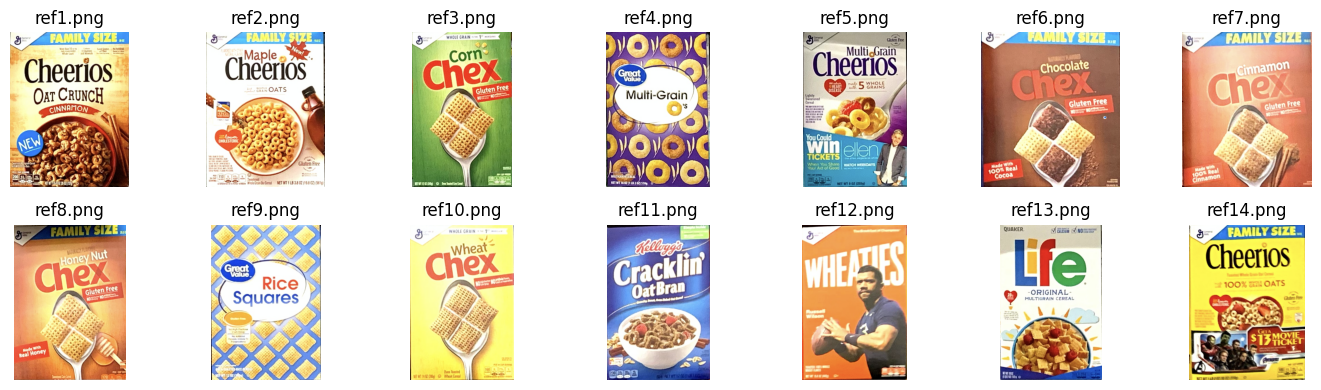

In [18]:
fig, axes = plt.subplots(2, 7, figsize=(14, 4))
axes = axes.flatten()

for i, product in enumerate(products_A):
    axes[i].imshow(cv2.cvtColor(cv2.imread(products_A[product]), cv2.COLOR_BGR2RGB))
    axes[i].axis('off')
    axes[i].set_title(products_A[product][len(models_path):])

plt.tight_layout()
plt.show()

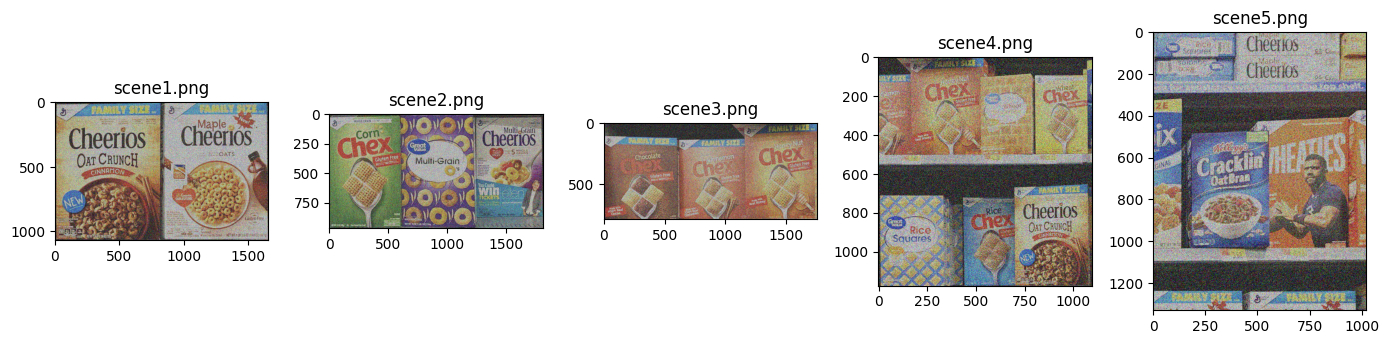

In [19]:
fig, axes = plt.subplots(1, 5, figsize=(14, 4))
axes = axes.flatten()

read_noisy_scenes_A = {}
for i, scene in enumerate(scenes_A):
    image = cv2.cvtColor(cv2.imread(scenes_A[scene]), cv2.COLOR_BGR2RGB)
    read_noisy_scenes_A[scene] = image
    axes[i].imshow(image)
    # axes[i].axis('off')
    axes[i].set_title(scenes_A[scene][len(scenes_path):])

plt.tight_layout()
plt.show()

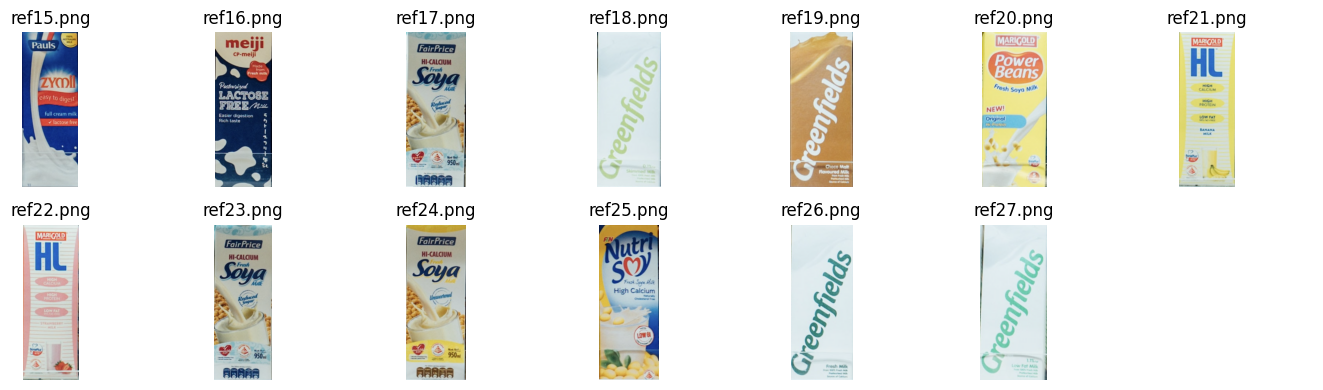

In [20]:
fig, axes = plt.subplots(2, 7, figsize=(14, 4))
axes = axes.flatten()

for i, product in enumerate(products_B):
    axes[i].imshow(cv2.cvtColor(cv2.imread(products_B[product]), cv2.COLOR_BGR2RGB))
    axes[i].axis('off')
    axes[i].set_title(products_B[product][len(models_path):])
    if i == len(products_B)-1:
        for ax in axes[i+1:]:
            ax.axis('off')

plt.tight_layout()
plt.show()

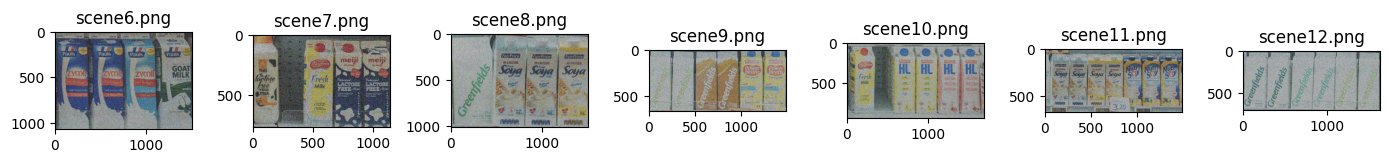

In [21]:
fig, axes = plt.subplots(1, 7, figsize=(14, 4))
axes = axes.flatten()

read_noisy_scenes_B = {}
for i, scene in enumerate(scenes_B):
    image = cv2.cvtColor(cv2.imread(scenes_B[scene]), cv2.COLOR_BGR2RGB)
    read_noisy_scenes_B[scene] = image
    axes[i].imshow(image)
    axes[i].set_title(scenes_B[scene][len(scenes_path):])

plt.tight_layout()
plt.show()

## TRACK A

Let' start by preparing a method to easily apply filters to an image...

In [22]:
def denoise_image(image, filters):
    '''
    Apply denoising filters to the input image.

    Parameters:
    image (array_like): The input image to be denoised.
    filters (list of dict): A list of dictionaries, each representing a denoising filter to be applied.
        Each dictionary should have the following keys:
            - name (str): The name of the filter.
            - n_iter (int): The number of iterations to apply the filter.
            - params (dict): A dictionary containing parameters specific to the filter.

    Returns:
    array_like: The denoised image.

    Example:
    >>> denoised_image = denoise_image(input_image, [
    >>>     {"name": "mean", "n_iter": 1, "params": {"ksize": 7}},
    >>>     {"name": "median", "n_iter": 1, "params": {"ksize": 5}},
    >>>     {"name": "bilateral", "n_iter": 1, "params": {"d": 3, "sigmaColor": 2, "sigmaSpace": 1.5}},
    >>>     {"name": "gaussian", "n_iter": 1, "params": {"sigmaX": 2}},
    >>>     {"name": "non_local_means", "n_iter": 1, "params": {"templateWindowSize": 5, "searchWindowSize": 21, "h": 3, "hColor": 20}},
    >>>     {"name": "canny", "n_iter": 1, "params": {"threshold1": 5, "threshold2": 21}},
    >>>     {"name": "sharpen", "n_iter": 1, "params": {}}, # 3x3 kernel
    >>>     {"name": "emboss", "n_iter": 1, "params": {}}   # 3x3 kernel
    >>> ])
    '''
    for filter in filters:
        for _ in range(filter['n_iter']):
            match filter['name']:
                case "mean":
                    '''
                    {"ksize" : 15}
                    '''
                    k_size = filter['params']['ksize']
                    mean_kernel = np.ones([k_size, k_size])/(k_size**2)
                    image = cv2.filter2D(image, -1, mean_kernel)
                case "median":
                    '''
                    {"ksize" : 11}
                    '''
                    image = cv2.medianBlur(image, **filter['params'])
                case "bilateral":
                    '''
                    {"d" : 3,
                    "sigmaColor" : 2,
                    "sigmaSpace" : 1.5}
                    '''
                    image = cv2.bilateralFilter(image, **filter['params'])
                case 'gaussian':
                    '''
                    {"sigmaX" : 2}
                    '''
                    sigmaX = filter['params']['sigmaX']
                    ksize = 2*int(np.ceil(3*sigmaX)) + 1
                    image = cv2.GaussianBlur(image, (ksize, ksize), sigmaX)
                case 'non_local_means':
                    '''
                    {'templateWindowSize':5,"searchWindowSize":21, "h":3, "hColor": 20}
                    '''
                    image = cv2.fastNlMeansDenoisingColored(image, **filter['params'])
                case 'canny':
                    '''
                    {'threshold1':5,"threshold2":21}
                    '''
                    image = cv2.Canny(image, **filter['params'])
                case 'sharpen':
                    kernel = np.array([[0, -1, 0],
                                       [-1, 5, -1],
                                       [0, -1, 0]])
                    image = cv2.filter2D(image, -1, kernel=kernel)
                case 'emboss':
                    kernel = np.array([[-2, -1, 0],
                                       [-1, 1, 1],
                                       [0, 1, 2]])
                    image = cv2.filter2D(image, -1, kernel=kernel)
                case _: pass
    return image

First thing is going to be applying SIFT on the products. We will store the keypoints found and the descriptors.
We are also going to store the read images, just to not have to read them again later.  
_We can use SHOW_KEYPOINTS to print/hide the plots after applying SIFT_

In [23]:
SHOW_KEYPOINTS = False

# this is going to store kp_query, des_query and the shape of the product, used for the homography
products_info_A = {}
read_products_A = {}
if SHOW_KEYPOINTS:
    fig, axes = plt.subplots(5, 3, figsize=(14, 20))
    axes = axes.flatten()

for i, product in enumerate(products_A):
    image = cv2.imread(products_A[product])
    read_products_A[product] = image
    sift = cv2.SIFT_create()
    keypoints = sift.detect(image)
    products_info_A[product] = list(sift.compute(image, keypoints))+[image.shape]
    if SHOW_KEYPOINTS:
        img_kp = cv2.drawKeypoints(image, keypoints, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
        axes[i].imshow(cv2.cvtColor(img_kp, cv2.COLOR_BGR2RGB))
        axes[i].axis('off')
        axes[i].set_title(products_A[product][len(models_path):])
        if i == len(products_A)-1:
            for ax in axes[i+1:]:
                ax.axis('off')

if SHOW_KEYPOINTS:
    plt.tight_layout()
    plt.show()

After some testing we found that the median filter were the best in therms of accuracy, in particular this combination:

In [ ]:
settings_A = [
    {'name': "median",
        "n_iter": 2,
        "params": {"ksize": 3}
     },
    {'name': "median",
        "n_iter": 2,
        "params": {"ksize": 5}
     },
    {'name': "median",
        "n_iter": 1,
        "params": {"ksize": 7}
     }
]

With the filters above, we try to denoise images and then compute SIFT. Once again we are going to store the results of SIFT, the shape of the images and the scenes read. For the scenes we store both the noisy and the denoised versions.

In [24]:
SHOW_KEYPOINTS = False
SHOW_FILTERED = False

if SHOW_KEYPOINTS or SHOW_FILTERED:
    fig, axes = plt.subplots(3, 2, figsize=(10, 15))
    axes = axes.flatten()

scenes_info_A = {}
read_scenes_A = {}
read_scenes_noisy_A = {}
for i, scene in enumerate(scenes_A):
    image = cv2.imread(scenes_A[scene])
    read_scenes_noisy_A[scene] = image
    filtered_image = denoise_image(image, settings_A)
    read_scenes_A[scene] = filtered_image
    sift = cv2.SIFT_create()
    keypoints = sift.detect(filtered_image)
    scenes_info_A[scene] = list(sift.compute(
        filtered_image, keypoints))+[image.shape]
    if SHOW_KEYPOINTS or SHOW_FILTERED:
        printable_image = image
        if SHOW_FILTERED:
            printable_image = filtered_image
        if SHOW_KEYPOINTS:
            printable_image = cv2.drawKeypoints(printable_image, keypoints, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
        axes[i].imshow(cv2.cvtColor(printable_image, cv2.COLOR_BGR2RGB))
        axes[i].set_title(scenes_A[scene][len(scenes_path):])
        # remove unused subplots
        if i == len(scenes_A)-1:
            for ax in axes[i+1:]:
                ax.axis('off')

if SHOW_KEYPOINTS or SHOW_FILTERED:
    plt.tight_layout()
    plt.show()

The method from _openCV_ to compute the homography returns the points of the polygon found. We use that points to extract the bouding box of that product, in therms of center position, width and height.  
These values are computed assuming that the points returned form a rectangle with no rotation. This is a big vague but most of the times the points are already precisely forming  rectangle. If not that's because the homography is a bit scuffed, but that product fill be removed later.

In [25]:
def diagonal(points, point2=None):
    if point2:
        return np.sqrt(np.abs((points[0]-point2[0])**2+(points[1]-point2[1])**2))
    return np.sqrt(np.abs(np.sum(np.subtract(points[:1, :], points[1:, :])**2)))


def get_geometry(corners):
    '''
    returns position(x,y), width, height.

    The center position is computed with the mean value of the x-coord and y-coord.
    Width and height using point-distance, knowing that the order of the points
    returned by the homography method is always the same (TL,BL,BR,TR)
    '''
    return {'position': tuple(np.round((np.sum(corners, axis=0)/4)[0], 0).astype(int)),
            'width': int(f'{diagonal(corners[1:3,:]):0.0f}'),
            'height': int(f'{diagonal(corners[:2,:]):0.0f}')
            }

We are now computing the matches between scenes and products. We will be store them in a dictionary, containing for every scene a dictionary containing the position of each product found. This nested dictionary has the keys _match_count_, the number of keypoints used to compute the homography, _geometry_ storing position and size of the product. There is an additional key named _flag_ that will be later set to false whenever a product isn' a good result.  
The try-except block is there cause of some errors that can occur with the _openCV_ methods. In that case the product analyze is not in the image, so we don't have to worry about that.

In [26]:
# resulting matches/positions will be stored here
results_A = {}

for i, scene in enumerate(scenes_info_A, 1):
    results_A[i] = {}
    for j, product in enumerate(products_info_A, 1):
        FLANN_INDEX_KDTREE = 1
        index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
        search_params = dict(checks=50)
        flann = cv2.FlannBasedMatcher(index_params, search_params)
        matches = flann.knnMatch(products_info_A[product][1], scenes_info_A[scene][1], k=2)
        good = []
        for m, n in matches:
            if m.distance < 0.7*n.distance:
                good.append(m)
                
        try: # to avoid homography errors happening with fewer than 4 points
            src_pts = np.float32([products_info_A[product][0][m.queryIdx].pt for m in good]).reshape(-1, 1, 2)
            dst_pts = np.float32([scenes_info_A[scene][0][m.trainIdx].pt for m in good]).reshape(-1, 1, 2)

            M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)
            matchesMask = mask.ravel().tolist()

            h, w,z = products_info_A[product][2] # the shape of the image was saved here
            pts = np.float32([[0, 0], [0, h-1], [w-1, h-1],[w-1, 0]]).reshape(-1, 1, 2)

            dst = np.int32(cv2.perspectiveTransform(pts, M))

            results_A[i][j] = {
                'match_count': np.sum(matchesMask), # the mask is used to pin the points used for the homography
                'geometry': get_geometry(dst), # returns the center position, width and height of the bounding box
                'flag':True # used later to check wheter or not to display the product
            }
        except cv2.error:
            print('cv2 error',f'scene {i} prod {j}')
            pass

cv2 error scene 3 prod 12


### Auxiliar mehods used to print the results

At this point we are ended up with a bunch of instances. Most of them are referring to the same product, so we have to find some heuristic to only keep the correct product.  
Firstly, we need something to detect if two bounding boxes insint in the same area. We simply check if the center of a bounding box lands inside another box:

In [ ]:
def check_boundings(point, geometry):
    '''
    checks wheter or not a point is inside a bounding box (computed using `get_geometry`)
    '''
    try:
        pointX, pointY = point
        centerX, centerY = geometry['position']
        sizeX = geometry['width']
        sizeY = geometry['height']
        return (centerX-sizeX/2 <= pointX and pointX <= centerX+sizeX/2) and (centerY-sizeY/2 <= pointY and pointY <= centerY+sizeY/2)
    except ValueError:
        return False

Whenever we detect two overlapping products we use the previously saved match count from earlier and we only keep the product with the most amount of matches found.

In [ ]:
def remove_overlapping_products_SI(results, method='overlapping_center', show_concentric_texts=False):
    '''
    Single Instance:
        for every couple of products in the same scene, if two products happen
      to be in the same region, only keep the one with the most matches
    '''
    for scene in results.keys():
        keys = list(results[scene].keys())
        for product1 in keys:
            for product2 in [k for k in keys if k != product1]:
                # this match clause was used to test multiple check methods
                # but we are only left with the working one
                match method:
                    case 'overlapping_center':
                        # tuple (x,y)
                        point = results[scene][product1]["geometry"]["position"]
                        if check_boundings(point, results[scene][product2]["geometry"]):
                            if show_concentric_texts:
                                print(
                                    f'scene {scene}: products {product1} and {product2} are found to be concentric')
                            if results[scene][product1]["match_count"] > results[scene][product2]["match_count"]:
                                # when choosing what instance to remove, we only remove it if the other one isn't removed
                                # this is a safe measure whenever two instances would have the same number of matches
                                # and both of them would be removed
                                if results[scene][product1]['flag']:
                                    results[scene][product2]["flag"] = False
                            else:
                                if results[scene][product2]["flag"]:
                                    results[scene][product1]["flag"] = False
                    case _: pass

Moreover some homography will result in bounding boxes outside the scene image, so we obviously remove them, using:

In [ ]:
def inside(center, image_shape):  # center is (x;y), shape is (rows,columns)
    '''
    used to detect if a point (the center of the bounding box) is inside the scene image
    '''
    return (center[0] >= 0 and center[0] < image_shape[1]) and (center[1] >= 0 and center[1] < image_shape[0])

### Printing methods

In [ ]:
def reflag_single_instance_products(results):
    '''
	Flag to True every product of the results
    '''
    for scene in results.keys():
        keys = list(results[scene].keys())
        for product in keys:
            results[scene][product]['flag'] = True

In [43]:
def display_settings(settings, value=None):
    '''
    print used filters and additional settings (used in track B)
    '''
    aux = [filter for filter in settings if ('matching_settings' in filter.keys() or filter['n_iter'] > 0)]
    print('Denoise settings:')
    if value:
        print(f'tollerance on template matcher: {value}')
    display(aux)


def print_single_instances(results: dict, min_match, check_pos, return_dict=False):
    # variables used to format the string
    max_product_len = max(len(str(product))for scene in results for product in results[scene].keys())
    max_match_len = max(len(str(results[scene][product]["match_count"]))for scene in results for product in results[scene])
    max_x_len = max(len(str(results[scene][product]["geometry"]["position"][0])) for scene in results for product in results[scene] if inside(
        results[scene][product]['geometry']['position'], scenes_info_A[scene][2]))
    max_y_len = max(len(str(results[scene][product]["geometry"]["position"][1])) for scene in results for product in results[scene] if inside(
        results[scene][product]['geometry']['position'], scenes_info_A[scene][2]))
    max_width_len = max(len(str(results[scene][product]["geometry"]["width"]))for scene in results for product in results[scene])
    max_height_len = max(len(str(results[scene][product]["geometry"]["height"]))for scene in results for product in results[scene])

    if return_dict:
        results_dict = {}

    for scene in results.keys():
        if return_dict:
            results_dict[scene] = {}
        print(f'Scene {scene}:')
        for product in results[scene].keys():
            if (  # the product must have a certain amount of matches
                    results[scene][product]['match_count'] >= min_match and
                # set to false in `remove_overlapping_products_SI` if refs refers to the same product (they both think to be the same product)
                    results[scene][product]['flag'] and
                    (  # check the position if you have to
                        (not check_pos) or
                        inside(results[scene][product]['geometry']
                               ['position'], scenes_info_A[scene][2])
                    )):
                if return_dict:
                    results_dict[scene][product] = results[scene][product]
                    
                print(f"\tProduct {str(product)+',':<{max_product_len+1}}"
                      # + f" matches: {str(results[scene][product]['match_count'])+',':<{max_match_len+1}}"
                      + f" {{position: ({str(results[scene][product]['geometry']['position'][0])+',':<{max_x_len+1}}"
                      + f" {str(results[scene][product]['geometry']['position'][1])+'),':<{max_y_len}}"
                      + f" width: {str(results[scene][product]['geometry']['width'])+',':<{max_width_len}}"
                      + f" height: {results[scene][product]['geometry']['height']:<{max_height_len-1}}}}")
    if return_dict:
        return results_dict

### RESULTS

These are all the command values usable to decide wich product to remove:
- _MIN_MATCH_COUNT_ to control the minimum number of matches that a product must have in order to be kept;
- _CHECK_IF_INSIDE_IMAGE_ used to remove products outside of the scene image

In [ ]:
MIN_MATCH_COUNT = 10
CHECK_IF_INSIDE_IMAGE = True

We can finally check our results using he methods explained:

In [29]:
# to avoid having multiple times this value when executing this cell with different parameters
if 'matching_settings' in settings_A[-1]:
    settings_A[-1]={'matching_settings':{'min_match':MIN_MATCH_COUNT,
                  'inside_position_check':'overlapping_center' if CHECK_IF_INSIDE_IMAGE else CHECK_IF_INSIDE_IMAGE}}
else:
    settings_A.append({'matching_settings':{'min_match':MIN_MATCH_COUNT,
                     'inside_position_check':'overlapping_center' if CHECK_IF_INSIDE_IMAGE else CHECK_IF_INSIDE_IMAGE}})
            
display_settings(settings_A)

# to be able to try different params without having to
# re-execute the whole matching process
reflag_single_instance_products(results_A) 
remove_overlapping_products_SI(results_A,)
products_found_A=print_single_instances(results_A,MIN_MATCH_COUNT,CHECK_IF_INSIDE_IMAGE,return_dict=True)

Denoise settings:


[{'name': 'median', 'n_iter': 2, 'params': {'ksize': 3}},
 {'name': 'median', 'n_iter': 2, 'params': {'ksize': 5}},
 {'name': 'median', 'n_iter': 1, 'params': {'ksize': 7}},
 {'matching_settings': {'min_match': 10,
   'inside_position_check': 'overlapping_center'}}]

Scene 1:
	Product 1,  {position: (412,  539), width: 803, height: 1046}
	Product 2,  {position: (1248, 533), width: 803, height: 1048}
Scene 2:
	Product 3,  {position: (305,  493), width: 604, height: 942 }
	Product 4,  {position: (927,  482), width: 631, height: 950 }
	Product 5,  {position: (1528, 450), width: 560, height: 841 }
Scene 3:
	Product 6,  {position: (298,  458), width: 598, height: 672 }
	Product 7,  {position: (888,  460), width: 540, height: 651 }
	Product 8,  {position: (1446, 398), width: 557, height: 780 }
Scene 4:
	Product 1,  {position: (886,  914), width: 377, height: 504 }
	Product 8,  {position: (353,  258), width: 350, height: 474 }
	Product 9,  {position: (173,  946), width: 334, height: 460 }
	Product 10, {position: (939,  290), width: 260, height: 397 }
Scene 5:
	Product 11, {position: (368,  751), width: 367, height: 552 }
	Product 12, {position: (714,  742), width: 439, height: 642 }


### Draw bounding boxes

We are going to use _cv2.polylines_ to draw the bounding box, so we need to compute the angles from the geometry dictionary:

In [30]:
def get_angles(geometry_dict):
    '''
    return the angles with shape (4,1,2)
    '''
    center_x, center_y = geometry_dict['position']
    width = geometry_dict['width']
    height = geometry_dict['height']
    
    top_left = np.array([center_x - width/2, center_y + height/2])
    bottom_left = np.array([center_x - width/2, center_y - height/2])
    bottom_right = np.array([center_x + width/2, center_y - height/2])
    top_right = np.array([center_x + width/2, center_y + height/2])
    corners = np.array([top_left, bottom_left, bottom_right, top_right]).reshape(4, 1, 2)
    
    return corners

We can now observe graphically the products found:

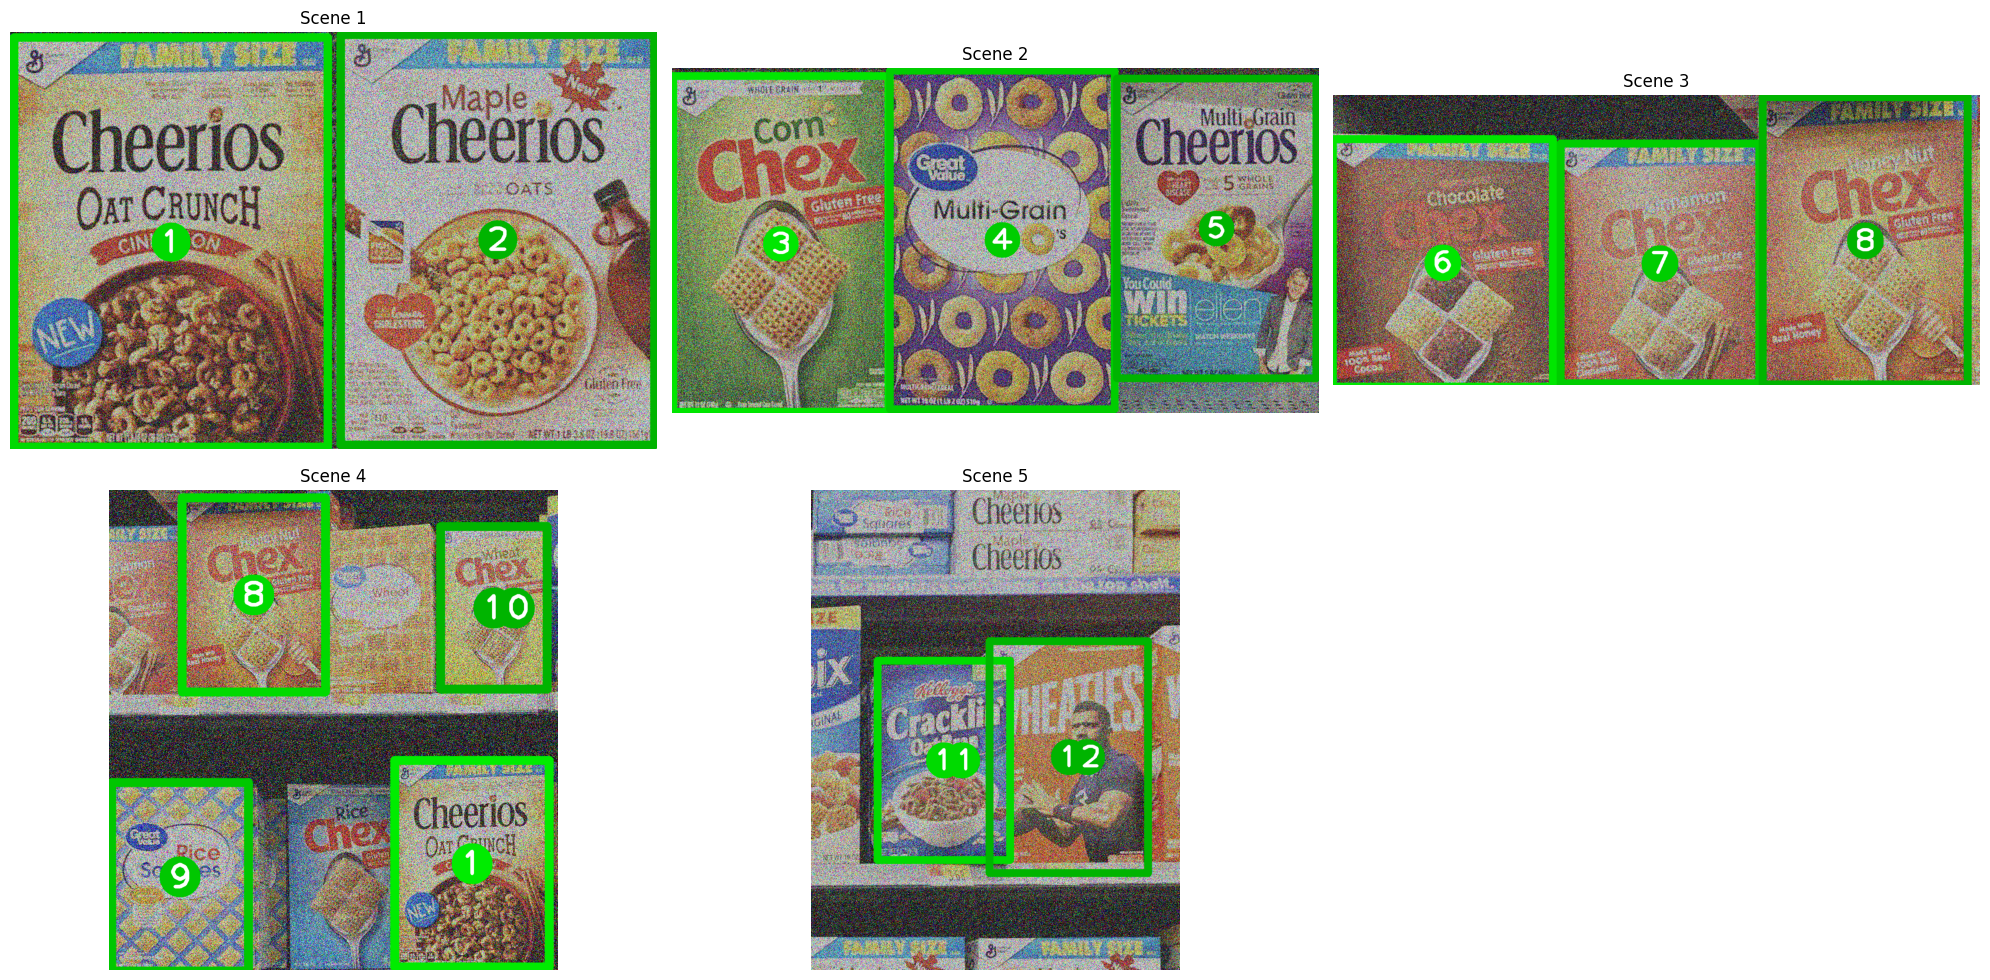

In [33]:
COLOR_RANGE=75
DRAW_CIRCLES=True
SHOW_NOISY_SCENES=True

fig, axes = plt.subplots(2, 3, figsize=(20, 10))
axes = axes.flatten()
for i, scene in enumerate(products_found_A):
    image=read_scenes_A[scene]
    if SHOW_NOISY_SCENES:
        image=read_scenes_noisy_A[scene]
    prods=len(products_found_A[scene].keys())
    for c,product in enumerate(products_found_A[scene]):
            points = get_angles(products_found_A[scene][product]['geometry'])
            color=[0,255-COLOR_RANGE+COLOR_RANGE*(prods-(c+1))/prods,0]
            image = cv2.polylines(image, [np.int32(points)], True, color, 20, cv2.LINE_AA)
            text=f'{product}'
            px,py=products_found_A[scene][product]['geometry']['position']
            if DRAW_CIRCLES:
                image=cv2.circle(image,(px,py),50,color,-1)
                if product>9:
                    image=cv2.circle(image,(px+50,py),50,color,-1)
                text_color=[255]*3
            else: 
                text_color=0
            px-=30
            py+=30
            image=cv2.putText(image,text,(px,py),cv2.FONT_HERSHEY_PLAIN,6,text_color,7)
    axes[i].imshow(cv2.cvtColor(image,cv2.COLOR_BGR2RGB))
    axes[i].axis('off')
    axes[i].set_title(f'Scene {scene}')
    if i == len(scenes_A)-1:
        for ax in axes[i+1:]:
            ax.axis('off')

plt.tight_layout()
plt.show()

## TRACK B

Let's apply sift on the products and storing the keypoints and the descriptors found, along with the shapes of the product images

In [60]:
SHOW_KEYPOINTS = False

products_info_B = {}
read_products_B = {}
if SHOW_KEYPOINTS:
    fig, axes = plt.subplots(3, 5, figsize=(14, 20))
    axes = axes.flatten()

for i, product in enumerate(products_B):
    image = cv2.imread(products_B[product])
    read_products_B[product] = image
    sift = cv2.SIFT_create()
    keypoints = sift.detect(image)
    products_info_B[product] = list(sift.compute(image, keypoints))+[image.shape]
    if SHOW_KEYPOINTS:
        img_kp = cv2.drawKeypoints(image, keypoints, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
        axes[i].imshow(cv2.cvtColor(img_kp, cv2.COLOR_RGB2BGR))
        axes[i].axis('off')
        axes[i].set_title(products_B[product][len(models_path):])
        if i == len(products_B)-1:
            for ax in axes[i+1:]:
                ax.axis('off')

if SHOW_KEYPOINTS:
    plt.tight_layout()
    plt.show()

We had no problem in track A, but to be able to correctly compare the images of track B we are going to use histograms, showing the color distribution of the images. Let's check the color distribution of a sample scene and a product:

In [73]:
print('Unique values in a scene:\n',np.unique(cv2.imread(scenes_path+'scene6.png')))
print('Unique values in a product:\n',np.unique(cv2.imread(models_path+'ref15.png')))

Unique values in a scene: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 221 222 223 224 225]
Unique values in a product: [  0   1   2   3   4   5   6

Since that the scenes seems to have been normalized down to 225, let's bring them back to 255 using interpolation. To do so we have prepared this method

In [ ]:
def normalize(image):
    '''
    Normalizes the image to 0-255, 
    calculating new values through linear interpolation
    '''
    max_value = np.max(image)
    new_image = np.interp(image, (0, max_value), (0, 255)).astype('uint8')
    return new_image

As for earlier, we used median filters. This time we do less denoising...

In [ ]:
settings_B = [
    {'name': "median",
        "n_iter": 2,
        "params": {"ksize": 3}
     },
    {'name': "median",
        "n_iter": 0,
        "params": {"ksize": 5}
     },
    {'name': "median",
        "n_iter": 1,
        "params": {"ksize": 7}
     }
]

In [61]:
SHOW_KEYPOINTS = False
SHOW_FILTERED = False

if SHOW_KEYPOINTS or SHOW_FILTERED:
    fig, axes = plt.subplots(4, 2, figsize=(14, 20))
    axes = axes.flatten()

scenes_info_B = {}
read_scenes_B = {}
read_scenes_noisy_B = {}
for i, scene in enumerate(scenes_B):
    image = cv2.imread(scenes_B[scene])
    read_scenes_noisy_B[scene] = image
    filtered_image = denoise_image(image, settings_B)
    sift = cv2.SIFT_create()
    keypoints = sift.detect(filtered_image)
    filtered_image = normalize(filtered_image)
    read_scenes_B[scene] = filtered_image
    scenes_info_B[scene] = list(sift.compute(filtered_image, keypoints))+[image.shape]
    if SHOW_KEYPOINTS or SHOW_FILTERED:
        printable_image = image
        if SHOW_FILTERED:
            printable_image = filtered_image
        if SHOW_KEYPOINTS:
            printable_image = cv2.drawKeypoints(filtered_image, keypoints, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
        axes[i].imshow(cv2.cvtColor(printable_image, cv2.COLOR_BGR2RGB))
        axes[i].set_title(scenes_B[scene][len(scenes_path):])
        # remove unused subplots
        if i == len(scenes_B)-1:
            for ax in axes[i+1:]:
                ax.axis('off')

if SHOW_KEYPOINTS or SHOW_FILTERED:
    plt.tight_layout()
    plt.show()

In [62]:
def get_histogram_score(product, scene, homography_geometry, method = cv2.HISTCMP_INTERSECT):
    '''TODO mettere method tra backtick
    method possibilities: HISTCMP_CORREL, HISTCMP_CHISQR, HISTCMP_INTERSECT, HISTCMP_BHATTACHARYYA, HISTCMP_HELLINGER, HISTCMP_CHISQR_ALT, HISTCMP_KL_DIV
    '''
    # if we want to use an higher number of bins (possibly up to 256(0, 255) it won't be possible to use HISTCMP_CORREL as metric
    # with the images we're using, since they're quite big and the compare method will return nan
    hist_sizes = [16, 16, 16]  
    ranges = [0, 256, 0, 256, 0, 256]
    product_image = read_products_B[product]
    scene_image = read_scenes_B[scene]
    scene_corners = get_angles(homography_geometry)
    
    # Slicing images where product is found
    row_min = min(max(int(min(a[0][1] for a in scene_corners)), 0), scene_image.shape[0]-1)
    row_max = max(min(int(max(a[0][1] for a in scene_corners)), scene_image.shape[0]-1),0)
    col_min = min(max(int(min(a[0][0] for a in scene_corners)), 0), scene_image.shape[1]-1)
    col_max = max(min(int(max(a[0][0] for a in scene_corners)), scene_image.shape[1]-1),0)
    scene_image = scene_image[row_min:row_max+1, col_min:col_max+1]
    
    # Computing histograms
    product_hists = cv2.calcHist([product_image], [0,1,2], None, hist_sizes, ranges)
    scene_hists = cv2.calcHist([scene_image], [0,1,2], None, hist_sizes, ranges)

    # Compare the histograms
    score = cv2.compareHist(product_hists, scene_hists, method)
    
    return score

In [63]:
def close_geometries(geom1, geom2, tolerance=40):
    '''
	Compare the distance between the centers.
    (The width and height will be the same due to the template window being of the same size)
    '''
    if (abs(geom1['position'][0] - geom2['position'][0]) <= tolerance and
        abs(geom1['position'][1] - geom2['position'][1]) <= tolerance):
        return True
    return False

In [64]:
def get4corners(top_left, bottom_right):
    '''
    return the 4 corners of a bounfing box, given the
    top left and the bottom right, returned by the template
    mathcer. Output is returned with shape (4,1,2)
    '''
    tl_x, tl_y = top_left
    br_x, br_y = bottom_right
    tr_x, tr_y = br_x, tl_y
    bl_x, bl_y = tl_x, br_y

    return np.array([[tl_x, tl_y], [bl_x, bl_y], [br_x, br_y], [tr_x, tr_y]]).reshape((4, 1, 2))

In [65]:
PRINT_PROGRESS=False

MIN_RESULT_VALUE = 0.27
# resulting matches/positions will be stored here
results_B = {}
for scene in scenes_info_B:
    results_B[scene] = {}
    best=0
    geom={}
    prod=0
    # find best product to use to get the dimensions of the window
    if PRINT_PROGRESS:print(f'----------SCENE {scene}----------')
    for product in products_info_B:
        try:
            matcher = cv2.BFMatcher()
            matches = matcher.knnMatch(products_info_B[product][1], scenes_info_B[scene][1], k=2)
            good = []
            for m, n in matches:
                if m.distance < 0.8*n.distance:
                    good.append(m)
            src_pts = np.float32([products_info_B[product][0][m.queryIdx].pt for m in good]).reshape(-1, 1, 2)
            dst_pts = np.float32([scenes_info_B[scene][0][m.trainIdx].pt for m in good]).reshape(-1, 1, 2)
            M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)
            matchesMask = mask.ravel().tolist()
            h, w = products_info_B[product][2][:2]
            pts = np.float32([[0, 0], [0, h-1], [w-1, h-1],[w-1, 0]]).reshape(-1, 1, 2)
            dst = np.int32(cv2.perspectiveTransform(pts, M))
            matches=np.sum(matchesMask)
            if matches>best:
                prod=product
                best=matches
                geom=get_geometry(dst)
            if PRINT_PROGRESS:print(f'matches for product {product}: {matches}')
        except: 
            print('\terror on SIFT')
    try:
        w=geom['width']
        h=geom['height']
    except:
        print('error with geom dict')

    if PRINT_PROGRESS:print('=======',f'best product found for scene {scene} is {prod} with {best} matches, size is w:{w}, h:{h}')
    # now use that window to compute template matching
    for product in products_info_B:
        positions_used=[]
        results_B[scene][product] = []
        # resize the product with the found dimension
        try:
            if PRINT_PROGRESS:print(f'matching {product} on scene {scene}')
            resized_product=cv2.resize(read_products_B[product],(w,h),interpolation=1)
            # search the template
            result = cv2.matchTemplate(read_scenes_B[scene], resized_product, cv2.TM_CCOEFF_NORMED)
            locations = np.where(result >= MIN_RESULT_VALUE)
            for loc in zip(*locations[::-1]):
                top_left=loc
                bottom_right=(top_left[0] + resized_product.shape[1], top_left[1] + resized_product.shape[0])
                angles=get4corners(top_left,bottom_right)
                geom=get_geometry(angles)

                # only append this box if it is in a position of a possible next product, 
                # and not in the same spot again
                interrupt=False
                if len(positions_used) > 0:
                    # new method: check if the current geom is 'similar'to one already stored
                    for old_geom in positions_used:
                        if close_geometries(geom,old_geom):
                            interrupt=True
                            break
                        
                if interrupt:
                    continue
                results_B[scene][product].append({
                    'match_count': np.inf,
                    'geometry': geom,
                    'flag':True,
                    'score': get_histogram_score(product,scene, homography_geometry=geom, method=cv2.HISTCMP_INTERSECT)
                    }
                )
                positions_used.append(geom)
            if PRINT_PROGRESS: print(f'trovate {len(results_B[scene][product])} istanze')
        except cv2.error:
            print('\terror on matcher',cv2.error)

	error on SIFT
	error on SIFT
	error on SIFT
	error on SIFT
	error on SIFT
	error on SIFT
	error on SIFT


### Auxiliar mehods used by the printing ones

In [66]:
def remove_overlapping_products_MI(results,method='color_center',method_param=75,show_actions = False):
    '''
    Multiple Instance:
	for every couple of instances in the same scene, if two products happen
    to be in the same region, only keep the one with the most matches.

    method='histogram_comparing' means that we search for bounding boxes whith
    center inside another bounding box, if so only keep the one with the best 
    score obtained with the histogram comparing between the window in the scene
    and the product assigned to that section of the image.
    '''
    for scene in results:
        keys=results[scene]
        for product1 in keys:
            for product2 in keys:
                for instance1 in range(len(results[scene][product1])):
                    # if a product is already flagged, do not compute it
                    if not results[scene][product1][instance1]["flag"]: 
                        continue
                    for instance2 in range(len(results[scene][product2])):
                        # if a product is already flagged, do not compute it
                        if not results[scene][product2][instance2]["flag"]:
                            continue
                        # if we check a product with himself we continue
                        if product1==product2 and instance1==instance2:
                            continue
                        # same as in track A, the match was used to test a bunch a strategies
                        match method:
                            case 'histogram_comparing':
                                point=results[scene][product1][instance1]["geometry"]["position"]
                                if check_boundings(point,results[scene][product2][instance2]["geometry"]):
                                    score1 = results[scene][product1][instance1]["score"]
                                    score2 = results[scene][product2][instance2]["score"]
                                    if show_actions:
                                        print(f'{scene}: {product1, point} and {product2,results[scene][product2][instance2]["geometry"]["position"]} concentric:\n1:{score1} - 2: , {score2}')
                                    # compare the histogram score of the two instances
                                    # the abs is due to old metrics that could have been negtive
                                    if np.abs(score1) > np.abs(score2):
                                        # when choosing what instance to remove, we only remove it if the other one isn't removed
                                        # this is a safe measure whenever two instances would have the same score
                                        # and both of them would be removed
                                        if results[scene][product1][instance1]["flag"]:
                                          results[scene][product2][instance2]["flag"] = False
                                    else:
                                        if results[scene][product2][instance2]["flag"]:
                                          results[scene][product1][instance1]["flag"] = False
                            case _:pass
                                

def reflag_products(results):
    for scene in results:
        keys=results[scene]
        for product in keys:
            for instance in range(len(results[scene][product])):
                results[scene][product][instance]['flag'] = True

### Print methods

In [67]:
def print_multiple_instances(results: dict,return_dict=False,order=True):
    max_product_len = max(len(str(product)) for scene in results for product in results[scene])
    max_instance_len = max(len(str(len(results[scene][product]))) for scene in results for product in results[scene])
    max_match_len = max(len(str(product["match_count"])) for scene in results for products in results[scene] for product in results[scene][products])
    max_score_len = max(len(str(product["score"])) for scene in results for products in results[scene] for product in results[scene][products])
    max_x_len = max(len(str(product["geometry"]["position"][0])) for scene in results for products in results[scene] for product in results[scene][products])# if inside(product['geometry']['position'], scenes_info_B[scene-1][2]))
    max_y_len = max(len(str(product["geometry"]["position"][1])) for scene in results for products in results[scene] for product in results[scene][products])# if inside(product['geometry']['position'], scenes_info_B[scene-1][2]))
    max_width_len = max(len(str(product["geometry"]["width"])) for scene in results for products in results[scene] for product in results[scene][products])
    max_height_len = max(len(str(product["geometry"]["height"])) for scene in results for products in results[scene] for product in results[scene][products])

    if return_dict:
        results_dict={}

    for i,scene in enumerate(results):
        if return_dict:
            results_dict[scene]={}
        print(f'Scene {scene}:')
        for products in results[scene]:
            printable_prods=[]
            for instance in results[scene][products]:
                if instance['flag']:
                    printable_prods.append(instance)
            num_inside=len(printable_prods)
            if num_inside>0:
                if return_dict:
                    results_dict[scene][products]=[]
                print(f"\tProduct {products:<{max_product_len}} - {num_inside} instance found:")
                if order: printable_prods = sorted(printable_prods, key=lambda instance: instance['geometry']["position"][0])
                for i,instance in enumerate(printable_prods,1):
                    if return_dict:
                        results_dict[scene][products].append(instance)
                    print(
                    f"\t\tInstance {str(i)+',':<{max_instance_len}}"
                    # + f" matches: {str(instance['match_count'])+',':<{max_match_len+1}}"
                    # + f" score: {str(instance['score'])+',':<{max_score_len+1}}"
                    + f" {{position: ({str(instance['geometry']['position'][0])+',':<{max_x_len+1}}"
                    + f" {str(instance['geometry']['position'][1])+'),':<{max_y_len}}"
                    + f" width: {str(instance['geometry']['width'])+'px,':<{max_width_len}}"
                    + f" height: {str(instance['geometry']['height'])+'px':<{max_height_len-1}}}}"
                    )
    if return_dict:
        return results_dict

### RESULTS

In [68]:
def double_check(results,max_tresh=0.5,instance_tresh=0.81):
    '''
	removes instances of products whose score is lower than some percentage of the maximum score of the scene
    and if it is lower than a certain percentage of the higher score of the instances of the same product
    '''
    for scene in results:
        max_scene_score=max([inst['score'] for p in results[scene] for inst in results[scene][p] if inst['flag']])
        # print(f'scene {scene}, max is {max_scene_score}')
        for product in results[scene]:
            try:
                max_product_score=max([inst['score'] for inst in results[scene][product] if inst['flag']])
            except ValueError:
                continue
            # print(f'max of {product} in {scene} is {max_product_score}')
            for instance in results[scene][product]:
                if instance['score']<max_tresh*max_scene_score or instance['score']<instance_tresh*max_product_score:
                    instance['flag']=False


In [69]:
CHECK_POSITION = True
CHECK_METHOD='histogram_comparing' # 'center_vicinity' or 'overlapping_center' or color_similarity or noisy_color_similarity or histogram_comparing
METHOD_PARAM=75
EXCEEDING_TOLLERANCE=20
MIN_AREA=50_000
            
print('Denoise settings:')
display_settings(settings_B,MIN_RESULT_VALUE)
reflag_products(results_B)
remove_overlapping_products_MI(results_B, method=CHECK_METHOD,method_param=METHOD_PARAM,show_actions=False)
# this double_check method adds some hard treshold to the instances, in order to remove false positives
double_check(results_B,max_tresh=0.5,instance_tresh=0.81)
products_found_B=print_multiple_instances(results_B,True,True)

Denoise settings:
tollerance on template matcher: 0.27


[{'name': 'median', 'n_iter': 2, 'params': {'ksize': 3}},
 {'name': 'median', 'n_iter': 1, 'params': {'ksize': 7}}]

Scene 6:
	Product 15 - 2 instance found:
		Instance 1, {position: (206,  602), width: 327px, height: 905px}
		Instance 2, {position: (590,  542), width: 327px, height: 905px}
Scene 7:
	Product 16 - 2 instance found:
		Instance 1, {position: (820,  460), width: 218px, height: 601px}
		Instance 2, {position: (960,  462), width: 218px, height: 601px}
Scene 8:
	Product 23 - 2 instance found:
		Instance 1, {position: (725,  560), width: 322px, height: 869px}
		Instance 2, {position: (984,  576), width: 322px, height: 869px}
	Product 24 - 1 instance found:
		Instance 1, {position: (1299, 564), width: 322px, height: 869px}
	Product 27 - 1 instance found:
		Instance 1, {position: (263,  580), width: 322px, height: 869px}
Scene 9:
	Product 18 - 2 instance found:
		Instance 1, {position: (126,  314), width: 231px, height: 556px}
		Instance 2, {position: (364,  343), width: 231px, height: 556px}
	Product 19 - 2 instance found:
		Instance 1, {position: (644,  382), width: 231px, height: 556px}
		I

### Draw bounding boxes

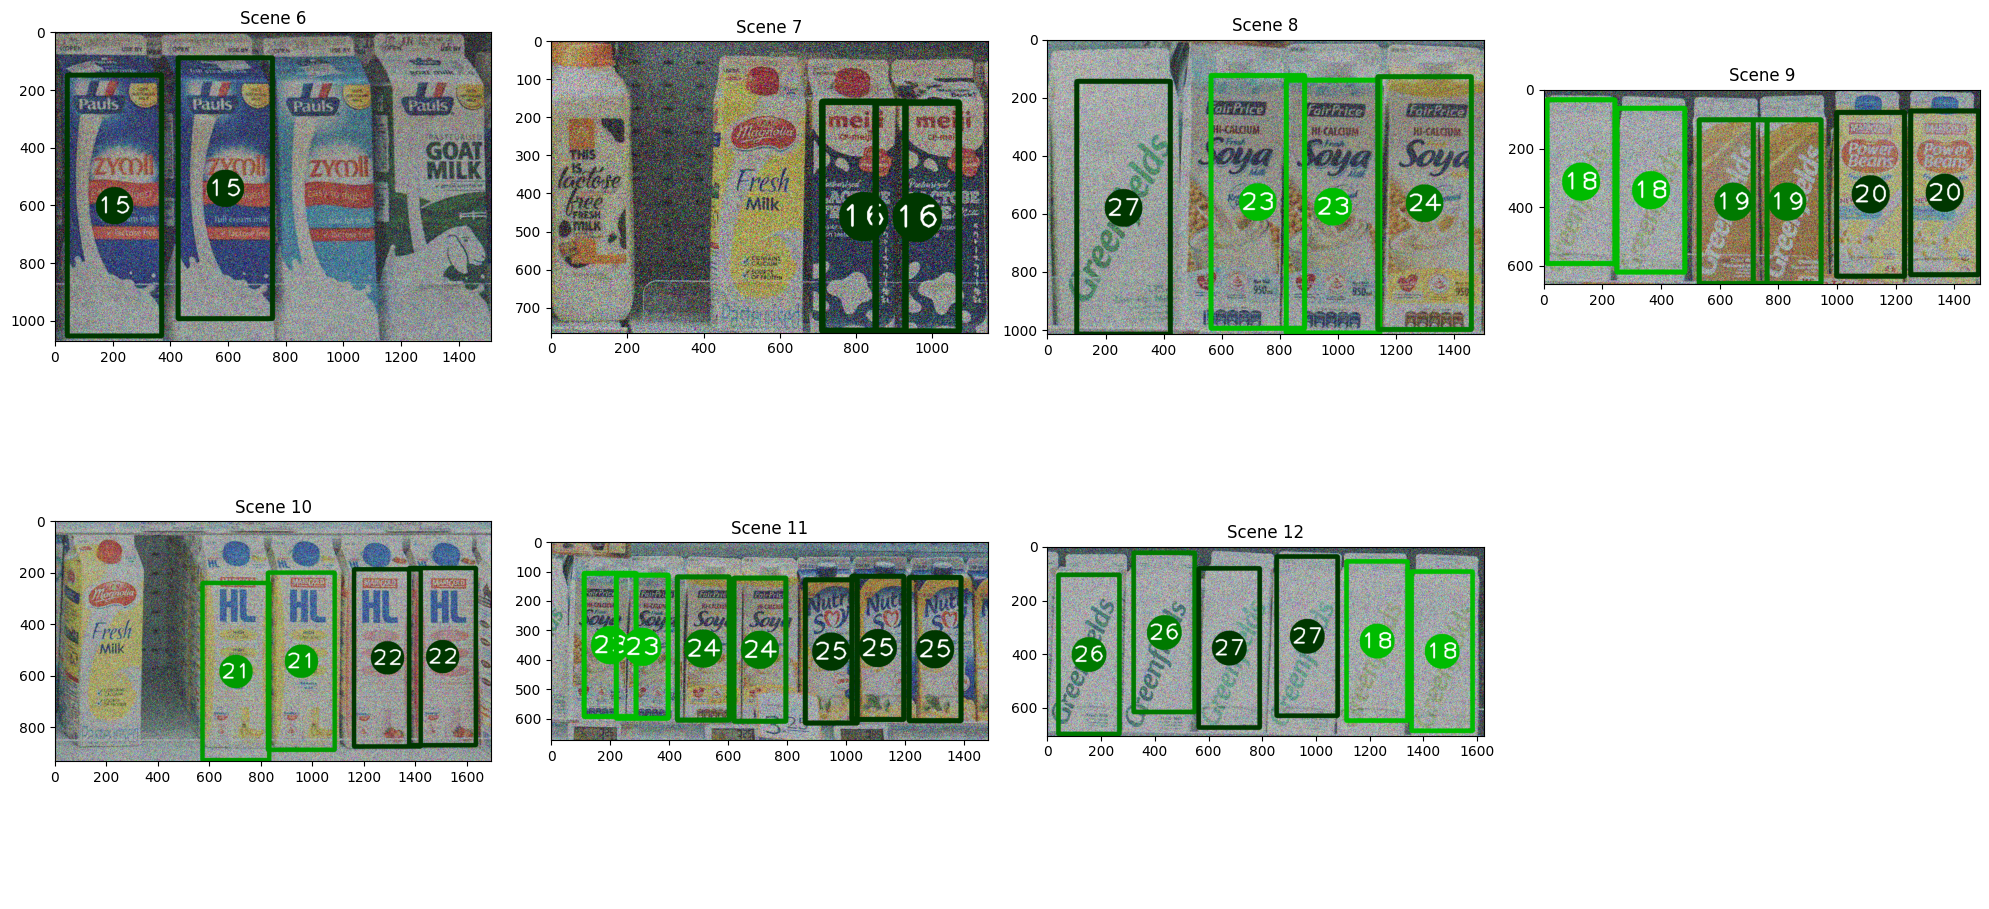

In [71]:
fig, axes = plt.subplots(2, 4, figsize=(20, 10))
axes = axes.flatten()
COLOR_RANGE=200
DRAW_CIRCLES=True
SHOW_DENOISED_SCENES=False
for i, scene in enumerate(products_found_B):
    image=read_scenes_noisy_B[scene]
    if SHOW_DENOISED_SCENES:
        image=read_scenes_B[scene]
    prods=len(products_found_B[scene].keys())
    for c,products in enumerate(products_found_B[scene]):
        for instance in products_found_B[scene][products]:
            points = get_angles(instance['geometry'])
            color=[0,255-COLOR_RANGE+COLOR_RANGE*(prods-(c+1))/prods,0]
            image = cv2.polylines(image, [np.int32(points)], True, color, 15, cv2.LINE_AA)
            text=f'{products}'
            px,py=instance['geometry']['position']
            if DRAW_CIRCLES:
                image=cv2.circle(image,(px,py),65,color,-1)
                text_color=[255]*3
            else: 
                text_color=0
            px-=60
            py+=30
            image=cv2.putText(image,text,(px,py),cv2.FONT_HERSHEY_PLAIN,6,text_color,5)
    axes[i].imshow(cv2.cvtColor(image,cv2.COLOR_BGR2RGB))
    axes[i].set_title(f'Scene {scene}')
    if i == len(scenes_B)-1:
        for ax in axes[i+1:]:
            ax.axis('off')

plt.tight_layout()
plt.show()